In [2]:
# Importing neccessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, Conv1D, MaxPooling1D, Flatten

In [3]:
# Loading the dataset
df = pd.read_csv('/content/demand-for-all-india-fro.csv')

In [4]:
# Preprocessing the data
df['Date'] = pd.to_datetime(df['Category'].str.split(':').str[0].str.strip(), format='%d-%m-%Y')

In [5]:
# Extracting 'Value' from 'Category' and converting it to integer
df['Value'] = df['Category'].str.split(':').str[1].astype(int)

In [6]:
# Dropping unnecessary columns
df.drop(["Category", "Value"], axis=1, inplace=True)

In [7]:
# Sort the DataFrame by date
df.sort_values(by='Date', inplace=True)

In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# Scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['All India']])

In [9]:
# Prepare the training data
X_train = []
y_train = []

# Range should be from 60 values to the end
for i in range(60, scaled_data.shape[0]):
    X_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [10]:
# Reshape X_train to have 3 dimensions
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [11]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
# Build the LSTM model with Bidirectional LSTM layers and Convolutional layers
regressor = Sequential()

regressor.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
regressor.add(MaxPooling1D(pool_size=2))
regressor.add(Flatten())

regressor.add(Dense(units=50, activation='relu'))

regressor.add(Dense(units=1))

regressor.compile(optimizer='adam', loss='mean_squared_error')

regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 60, 100)           20800     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 58, 64)            19264     
                                                                 
 max_pooling1d (MaxPooling1  (None, 29, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1856)              0         
                                                                 
 dense (Dense)               (None, 50)                9

In [12]:
# Fit the model
regressor.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
1094/1094 [==============================] - 19s 10ms/step - loss: 0.0077
Epoch 2/50
1094/1094 [==============================] - 17s 16ms/step - loss: 0.0052
Epoch 3/50
1094/1094 [==============================] - 12s 11ms/step - loss: 0.0049
Epoch 4/50
1094/1094 [==============================] - 10s 9ms/step - loss: 0.0047
Epoch 5/50
1094/1094 [==============================] - 11s 10ms/step - loss: 0.0044
Epoch 6/50
1094/1094 [==============================] - 11s 10ms/step - loss: 0.0041
Epoch 7/50
1094/1094 [==============================] - 11s 10ms/step - loss: 0.0038
Epoch 8/50
1094/1094 [==============================] - 11s 10ms/step - loss: 0.0036
Epoch 9/50
1094/1094 [==============================] - 11s 10ms/step - loss: 0.0034
Epoch 10/50
1094/1094 [==============================] - 11s 10ms/step - loss: 0.0032
Epoch 11/50
1094/1094 [==============================] - 11s 10ms/step - loss: 0.0030
Epoch 12/50
1094/1094 [==============================] - 11s 10m

In [13]:
# Prepare the testing set
testing_set = df.tail(1000)
inputs = df[len(df) - len(testing_set) - 60:].drop(columns=['Date']).values
inputs = scaler.transform(inputs)

X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [14]:
# Predict
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

32/32 [==============================] - 1s 7ms/step


In [15]:
# Compare true demand with predicted demand
True_Demand = testing_set["All India"].to_list()
Predicted_Demand = predicted_stock_price.flatten()
dates = testing_set['Date'].to_list()

In [18]:
Machine_Df = pd.DataFrame(data={
    "Date": dates,
    "True_Demand": True_Demand,
    "Predicted_Demand": Predicted_Demand
})

Machine_Df['Demand_Deviation'] = abs(Machine_Df['True_Demand'] - Machine_Df['Predicted_Demand'])
Machine_Df['Demand_Deviation_Percentage'] = (abs(Machine_Df['True_Demand'] - Machine_Df['Predicted_Demand']) / Machine_Df['True_Demand']) * 100

In [19]:
Machine_Df

,Date,True_Demand,Predicted_Demand,Demand_Deviation,Demand_Deviation_Percentage
0,2023-12-21,136917,136028.765625,888.234375,0.648739
1,2023-12-21,136711,137025.218750,314.218750,0.229842
2,2023-12-21,137538,140182.000000,2644.000000,1.922378
3,2023-12-21,137770,139999.734375,2229.734375,1.618447
4,2023-12-21,137971,139997.375000,2026.375000,1.468696
...,...,...,...,...,...
995,2023-12-31,165664,172121.953125,6457.953125,3.898224
996,2023-12-31,161216,169068.968750,7852.968750,4.871085
997,2023-12-31,158460,166960.265625,8500.265625,5.364297
998,2023-12-31,204542,184425.468750,20116.531250,9.834915


In [20]:
True_Demand = testing_set["All India"].tolist()
Predicted_Demand = [x[0] for x in predicted_stock_price]
dates = testing_set.index.tolist()

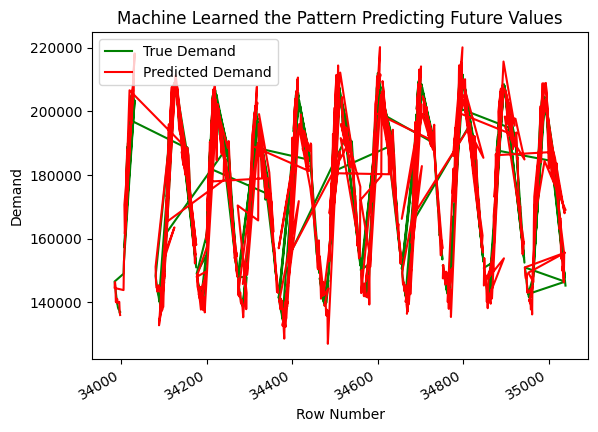

In [21]:
import matplotlib.pyplot as plt

# Plotting the true and predicted MegaWatt values over time
fig = plt.figure()
ax1 = fig.add_subplot(111)

x = dates
y = True_Demand
y1 = Predicted_Demand

plt.plot(x, y, color="green", label="True Demand")
plt.plot(x, y1, color="red", label="Predicted Demand")

# Beautify the x-labels
plt.gcf().autofmt_xdate()

plt.xlabel('Row Number')
plt.ylabel("Demand")
plt.title("Machine Learned the Pattern Predicting Future Values")
plt.legend()

plt.show()